In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Exploration:

The scope of this project is to build several deep learning algorithms based on RNN techniques which can predict future values of an indicator using Time-Series Forecasting methods in order to achieve the highest possible accuracy.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

df=pd.read_csv('/content/drive/MyDrive/Capstone Project - Stock Market Prediction/Datasets/yahoo_stock.csv')

In [3]:
from tensorflow.keras.optimizers import Adam
import statistics

In [4]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
df.shape

(1825, 7)

In [6]:
len(df['Date'].unique())

1825

As there are 1825 unique dates means that each one corresponds to unique records in the table, therefore we don't have duplicated or inconsistent values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1825 non-null   object 
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Open       1825 non-null   float64
 4   Close      1825 non-null   float64
 5   Volume     1825 non-null   float64
 6   Adj Close  1825 non-null   float64
dtypes: float64(6), object(1)
memory usage: 99.9+ KB


In [8]:
df.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [9]:
df.Date=pd.to_datetime(df['Date'])

In [10]:
df.Date.min(),df.Date.max()

(Timestamp('2015-11-23 00:00:00'), Timestamp('2020-11-20 00:00:00'))

Let's compute the amount of days between the limits in the table, i.e. 2017-05-15/2022-05-13, take into account that the result will give us the days. Setting the date as index will make our time series plots much more understandable.:

In [11]:
df.Date.max()-df.Date.min()

Timedelta('1824 days 00:00:00')

In [12]:
df.set_index('Date',inplace=True)

In [13]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


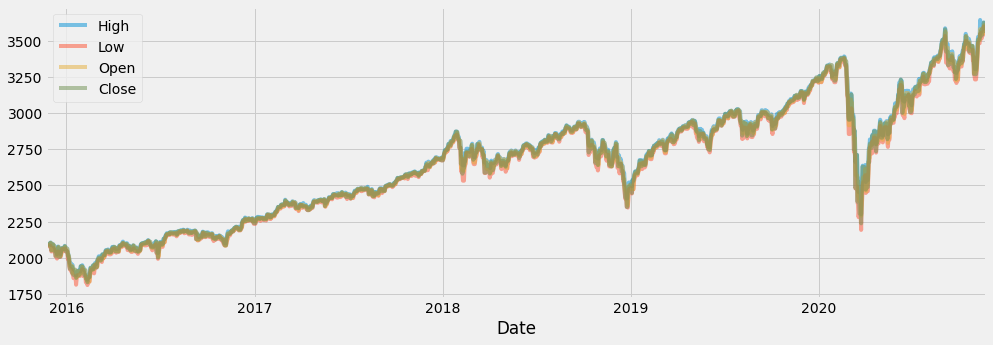

In [14]:
df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.5)

 if the time-series problem corresponds to a Non-Stationary type, which characterizes for having:

1.   Non-constant variance.
2.   Non-constant mean.
3.   Seasonality.
4.   High autocorrelation.

There are four well known ways to evaluate if the serie meets the criteria just mentioned, these corresponds to:

*   Sequence visualization.
*   Histogram, Autocorrelation and Partial Aurocorrelation plots.
*   Statistical summary of chunks.
*   Adfuller test





Evaluating stationarity:

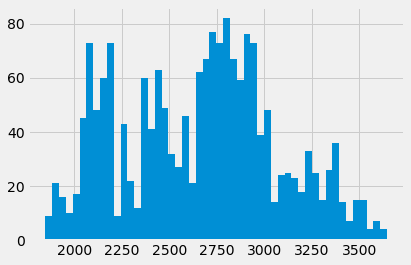

In [15]:
df.High.hist(bins=50)

We can't assume a uniform nor normal distribution in the plot above, because of that the statistical summary can helps us more, for this we will split the data into 10 chunks and compute mean and variance of each one.

In [16]:
np.round(df.shape[0]/10,0)

182.0

In [17]:
from statistics import stdev
mean=[]
std=[]
    
for i in range(0,10):
    mean.append(df['High'].iloc[(i*182):(i*182)+182].mean())
    std.append(stdev(df['High'].iloc[(i*182):(i*182)+182]))

In [18]:
pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1)

,mean,std
0,2019.354300,71.041024
1,2147.740282,36.287599
2,2322.969570,60.228422
3,2489.706581,55.878102
4,2711.253743,63.125935
5,2816.088946,68.351685
6,2754.165647,131.792411
7,2965.153137,74.059325
8,3045.669328,267.695412
9,3309.076588,165.733813


Above we see how both measures are clearly different in each chunk. However looking at the plot we could assume a constant variance as the ripple in the curve, but without a doubt trend is the most outstanding feature. Until now can assume it's a non-stationary serie, but to know more about it we will evaluate two other methods.
Seasonal decomposition is a function from statsmodels library which allows us to decompose the serie into trend, seasonal and residual, either additive or multiplicative

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


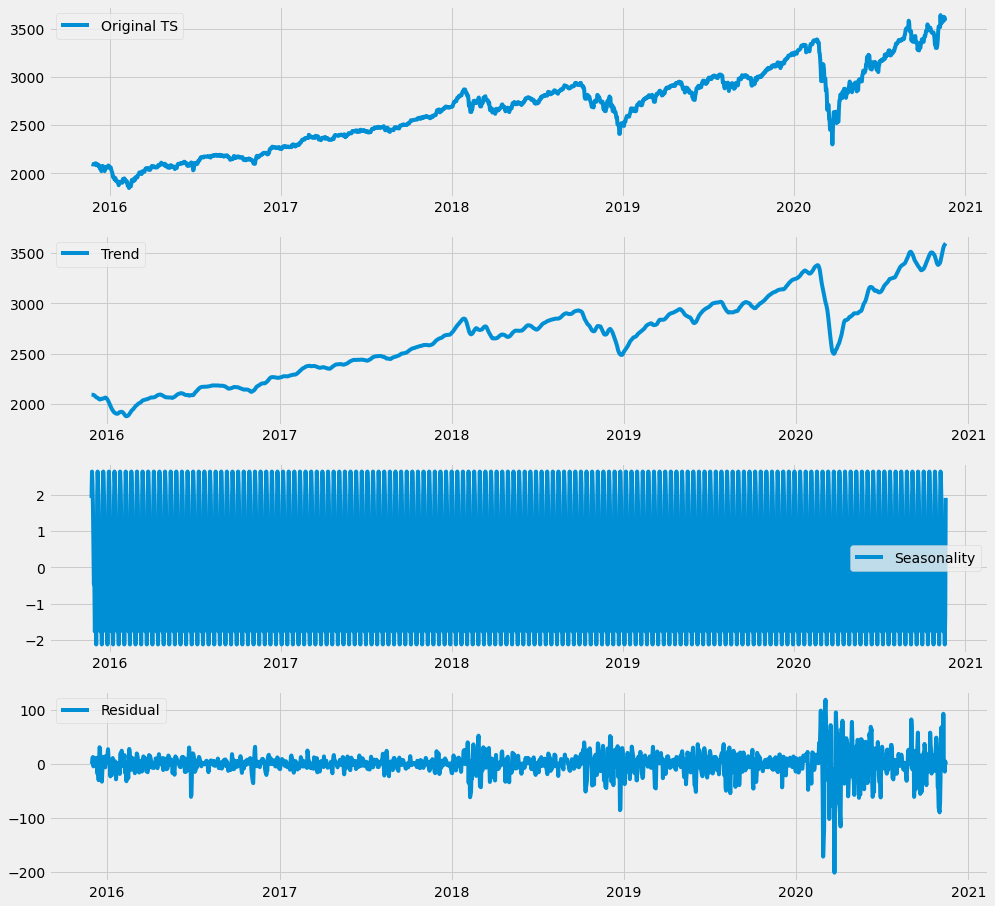

In [20]:
decompose_add=seasonal_decompose(df['High'], model='additive', freq=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

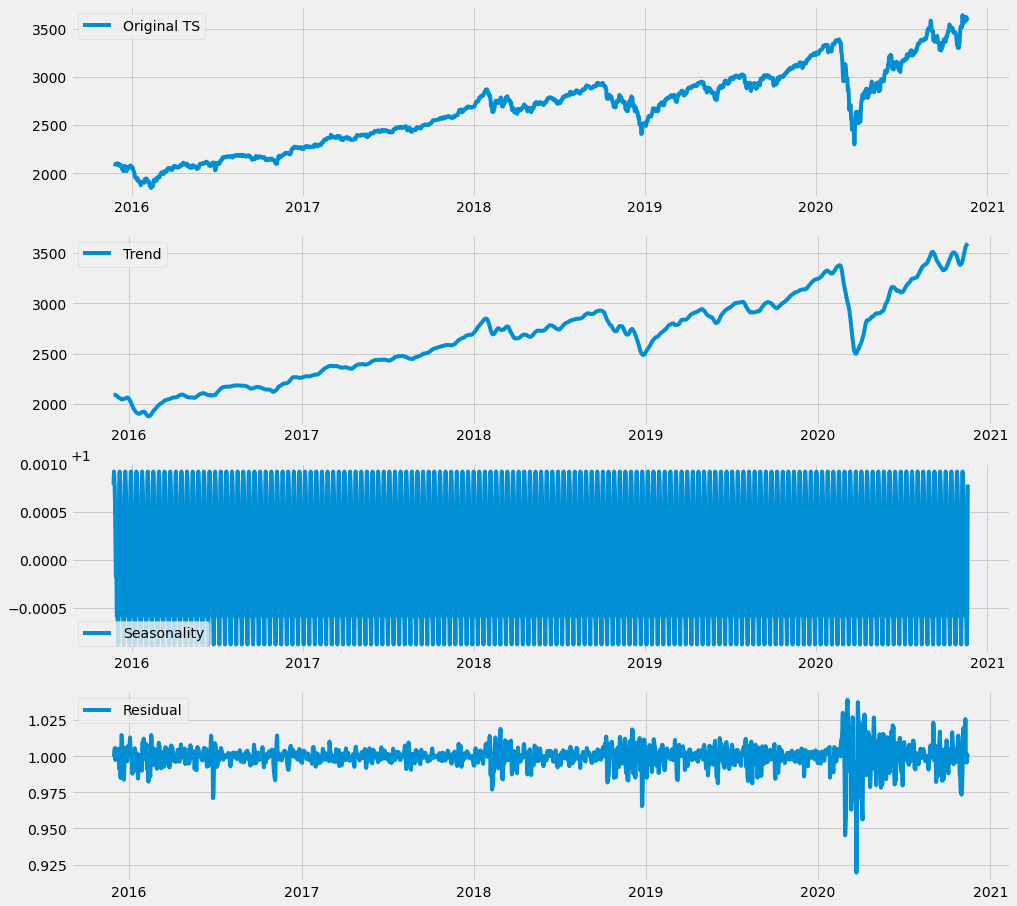

In [21]:
decompose_mul=seasonal_decompose(df['High'], model='multiplicative', freq=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mul.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mul.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mul.resid, label='Residual')
plt.legend(loc='best')

Looking carefully to the original curve we can say the additive decomposition makes more sense as the trend does not seem to be changing by the multiplication with seasonal component, rather every component seems to being added up to create the original curve. Independent of this there is a trend and seasonal component.
Below we can see the ACF and PACF plots:

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

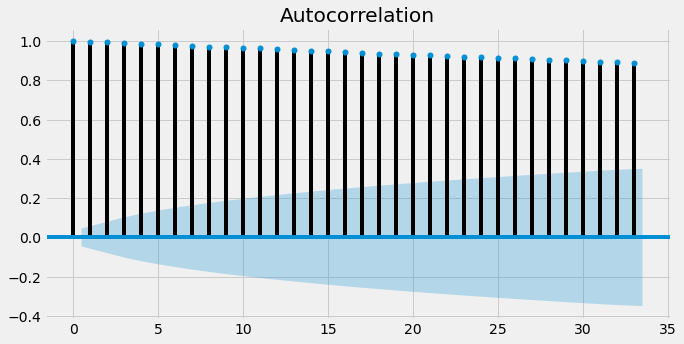

In [23]:
plt.rc("figure", figsize=(10,5))
plot_acf(df['High'])
print()

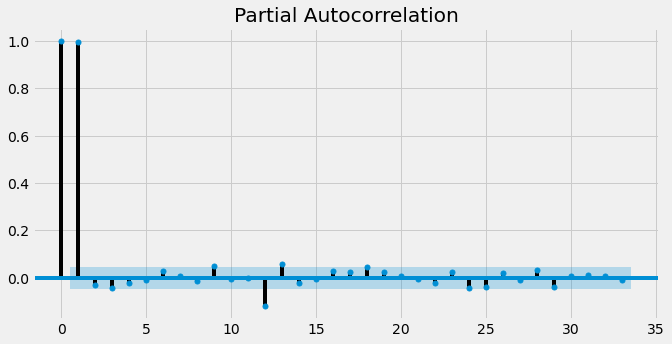

In [24]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['High'])
print()

Finally, we will make the Augmented Dickey-Fuller test, using 5% as significance level and declaring the following hypothesis:


*   H0= Serie corresponds to non-stationary type.
*   H1= Serie corresponds to stationary type.




In [25]:
from statsmodels.tsa.stattools import adfuller

In [26]:
result = adfuller(df['High'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.713598
p-value: 0.843196
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


As p-value is greater than 0.05 we fail to reject the null hypothesis, therefore there is not enough evidence to reject that we are working with a non-stationary series. Let's apply the log transformation to the serie and test again.

In [27]:
from numpy import log

result = adfuller(log(df['High']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.920468
p-value: 0.781157
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Based on every method applied we can endorse the serie clearly corresponds to a non-stationary type, which means that we have to convert this to stationary by using filters and complex transformations. However, deep learning approaches can lead us to build models which takes into account all of these characteristics and predict future values modestly, but as disadvantage it would take significantly more time to train such models

Modeling:

In order to choose the best model 4 changes in hyperparameters and architecture will be applied and then evaluate each one by computing their corresponding error metrics.  Each step will be denominated ‘comparison’ and are detailed as follows:

*   1st comparison, model with 7 different window length.
*    2nd comparison, model with more layers, neurons and epochs.
*    3rd comparison, model with regularization.
*    4th comparison, model using SimpleRNN vs LSTM.

Firstly, we will define a new dataset equal to the existing one, but omitting the last four records, later we will use the model to predict such values.

In [28]:
new_df=df['High'].iloc[:-4]

We define the length of the training set as 80% of the total records (specifically the first 80% of data):

In [29]:
train_len = math.ceil(len(new_df)*0.8)
train_len

1457

In [30]:
window=10

The following lines create the training sets, as we now the first row takes the first 10 time steps and then the second row takes time steps shifted in one and so on and so forth:

In [31]:
train_data = new_df[0:train_len]

X_train=[]
Y_train=[]

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

In [32]:
X_train, Y_train= np.array(X_train), np.array(Y_train)

In [33]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1447, 10, 1)

In [34]:
X_train

array([[[2095.61010742],
        [2094.12011719],
        [2093.        ],
        ...,
        [2093.81005859],
        [2103.37011719],
        [2104.27001953]],

       [[2094.12011719],
        [2093.        ],
        [2093.        ],
        ...,
        [2103.37011719],
        [2104.27001953],
        [2085.        ]],

       [[2093.        ],
        [2093.        ],
        [2093.29003906],
        ...,
        [2104.27001953],
        [2085.        ],
        [2093.84008789]],

       ...,

       [[3078.34008789],
        [3097.77001953],
        [3093.09008789],
        ...,
        [3098.06005859],
        [3098.19995117],
        [3120.45996094]],

       [[3097.77001953],
        [3093.09008789],
        [3093.09008789],
        ...,
        [3098.19995117],
        [3120.45996094],
        [3120.45996094]],

       [[3093.09008789],
        [3093.09008789],
        [3093.09008789],
        ...,
        [3120.45996094],
        [3120.45996094],
        [3120.45996094]]

The following is the first model to be used, this is relatively simple with one LSTM layer with relu activation function and one hidden fully connected layer, the optimizer used is Adam, number of epochs=10, batch_size=10 and loss function=Mean squared error:

In [35]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [36]:
model=Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


Creating the validation set using same logic as training:

In [37]:
test_data = new_df[train_len-window:]

X_val=[]
Y_val=[] 

for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])

In [38]:
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [39]:
X_val.shape, Y_val.shape

((364, 10, 1), (364,))

In [40]:
prediction = model.predict(X_val)

In [41]:
len(prediction), len(Y_val)

(364, 364)

As our prediction and actual values have the same shape we can use these sets to compute the error metrics, in this case we will use RMSE.

In [42]:
from sklearn.metrics import mean_squared_error

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

Train rmse: 29.642390845650965
Validation rmse: 82.19811195041517


Both errors are high, if we specifically see the validation one we could say it's too much and we aim to improve this as we build a robust model in the next steps.
Below is a table which merged the actual and predicted values, therefore we can see for each record how differ these two and have an idea of how sidetracked we currently are.

In [43]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,High,Predictions
Date,,
2019-11-19,3127.639893,3104.893066
2019-11-20,3118.969971,3107.548340
2019-11-21,3110.110107,3109.601318
2019-11-22,3112.870117,3108.650146
2019-11-23,3112.870117,3111.123535
...,...,...
2020-11-12,3569.020020,3474.364502
2020-11-13,3593.659912,3509.877197
2020-11-14,3593.659912,3542.595947


Below we can see a simple plot showing both curves, in which clearly there is a difference and a sort of shift to the right or delay in the prediction curve.

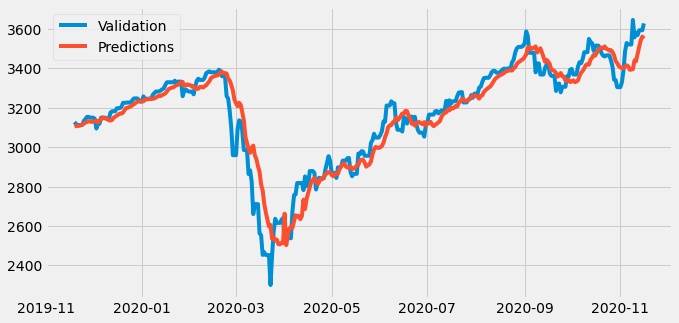

In [44]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

Finally, the plot showing training, validation and prediction curves:

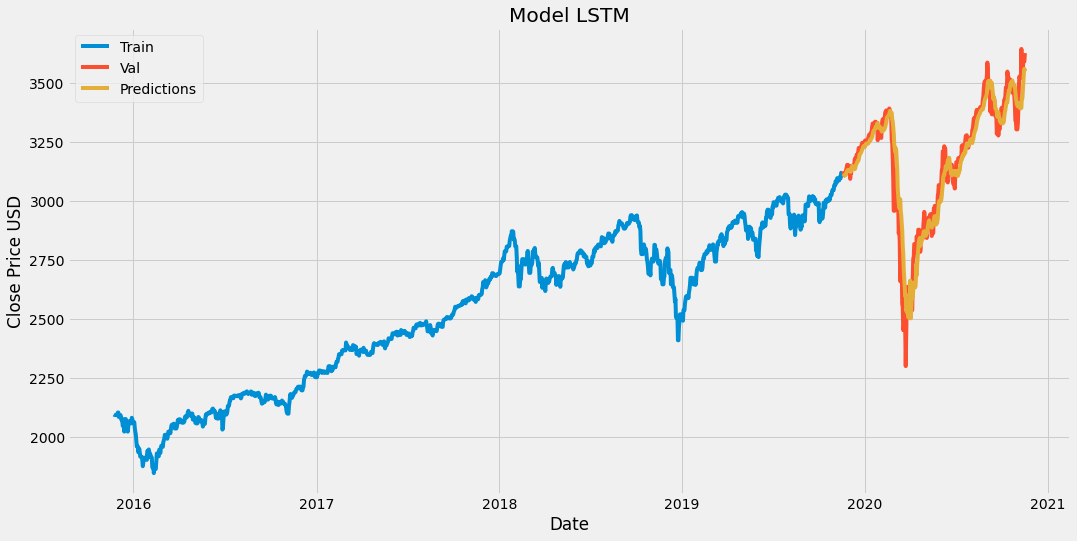

In [45]:
train = new_df[:train_len]
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred

plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid[['High','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show()

1st comparison:

In order to tackle down this 'shift' and thus reduce the error we have to find the suit window number, for this we will compute the RMSE for the following number of windows: 5,8,10,15,20,30,40. Then compare results and find the lowest.

In [47]:
train_error=[]
val_error=[]

window_number=[5,8,10,15,20,30,40]
for i in window_number:
    #_____________________________________________________________________
    train_data = new_df[0:train_len]

    X_train=[]
    Y_train=[]

    for i in range(window, len(train_data)):
        X_train.append(train_data[i-window:i])
        Y_train.append(train_data[i])

    X_train, Y_train= np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    #______________________________________________________________________
    test_data = new_df[train_len-window:]

    X_val=[]
    Y_val=[] 

    for i in range(window, len(test_data)):
      X_val.append(test_data[i-window:i])
      Y_val.append(test_data[i])
    
    X_val, Y_val = np.array(X_val), np.array(Y_val)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))
    #______________________________________________________________________
    model=Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)
    #______________________________________________________________________
    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    train_error.append(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
    val_error.append(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

In [48]:
train_error

[28.434551000668183,
 14.330254574325672,
 38.18871247210887,
 26.178561930168826,
 30.075211116738338,
 34.57432258600913,
 25.033077596971367]

In [49]:
val_error

[75.66789857717238,
 37.97087700930395,
 177.97490448102036,
 79.73034370841651,
 79.99541133816496,
 94.78053636277545,
 69.4426521895643]

The following table shows the RMSE of train and validation sets for each of the 7 windows:

In [50]:
pd.concat([pd.DataFrame(train_error,columns=['train_error']),
           pd.DataFrame(val_error,columns=['val_error']),
           pd.DataFrame([5,8,10,15,20,30,40],columns=['window'])], axis=1).set_index('window')

,train_error,val_error
window,,
5,28.434551,75.667899
8,14.330255,37.970877
10,38.188712,177.974904
15,26.178562,79.730344
20,30.075211,79.995411
30,34.574323,94.780536
40,25.033078,69.442652


Each time prior code was run for 7 windows the outcome was different, but in general the behaviour was as in the table above, having window=10 the lowest RMSE for validation set. Thus this number was chosen as the best predictor. Even though before we have seen how for this value the shift was significant for all other windows this difference was much more, but there are still more hyperparameters to tune in order to improve the accuracy.

2nd comparison:

One efficient way to improve the accuracy is by simply increasing the complexity of the model and this can be achieved adding more layers and more LSTM cells. Therefore in this step we will build a multilayered model and compare its performance with the prior.
Firstly, let's create again the training and validation sets for 30 windows to be used.

In [51]:
window=10

train_data = new_df[0:train_len]
X_train=[]
Y_train=[]
for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])

X_train, Y_train= np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
test_data = new_df[train_len-window:]
X_val=[]
Y_val=[] 
for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])
    
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

The following is the architecture of the model to be used (2 LSTM layers and 2 hidden fully-connected layers), the optimizer is more specific and the number of epochs was increased to 100:

In [52]:
model=Sequential()
model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False,activation='relu'))
model.add(Dense(100))
model.add(Dense(25))
model.add(Dense(1))
opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=opt1)
model.summary()
model.fit(X_train, Y_train, epochs=100, batch_size=10, verbose=0)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dense_24 (Dense)            (None, 100)               5100      
                                                                 
 dense_25 (Dense)            (None, 25)                2525      
                                                                 
 dense_26 (Dense)            (None, 1)                 26        
                                                                 
Total params: 38,251
Trainable params: 38,251
Non-trainable params: 0
_________________________________________________________________


In the summary above we can see that the total parameters of this new model is three times or even more than the prior which is indicative of the complexity and the time it takes to train.

In [53]:
lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))

Train rmse: 41.2566903280682
Validation rmse: 83.1062346257074


In [54]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred

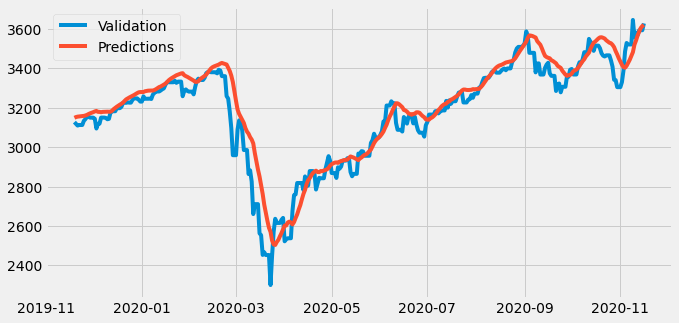

In [55]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()

Despite the fact that error metrics were lower than before in the plot above we still can see a gap between the actual and predicted values.Each time this model is run the results were different and the current output corresponds to the very best one, but in order to better vizualize this we ran the same model 10 times and computed the errors in each one.

In [56]:
r1=[]
r2=[]

for i in range(0,10):
    model=Sequential()
    model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(LSTM(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)
    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    r1.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    r2.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))

Below we can see the RMSE for each time, note that these are considerably different, being still more impactful in the validation set.

In [57]:
r1, statistics.mean(r1), statistics.stdev(r1)

([31.22, 33.66, 16.19, 24.93, 19.82, 32.09, 28.5, 32.64, 56.3, 22.02],
 29.737,
 11.071504013055819)

In [58]:
r2, statistics.mean(r2), statistics.stdev(r2)

([85.76, 89.01, 43.66, 53.12, 50.31, 87.62, 74.08, 90.23, 105.73, 49.51],
 72.903,
 21.920934717499822)

We can see how validation errors are higher than training and also more spreaded because of such stardard deviation.

3rd comparison:

As the validation errors were still considerably higher than training we think one reason could be due to overfitting and for this problem we have to add regularization to the model chosen by using Dropout after Fully Connected layers and LSTM cells. In this step we will run a regularized model again 10 times in order to see the variation in the results:

In [60]:
r1=[]
r2=[]

for i in range(0,10):
    model=Sequential()
    model.add(LSTM(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1),recurrent_dropout=0.2))
    model.add(LSTM(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=10,verbose=0)

    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    r1.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    r2.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))

In [61]:
r1, statistics.mean(r1), statistics.stdev(r1)

([34.23, 80.59, 36.93, 28.74, 38.56, 56.5, 40.46, 38.35, 62.59, 46.69],
 46.364,
 15.79159565507341)

In [62]:
r2, statistics.mean(r2), statistics.stdev(r2)

([94.51, 137.04, 97.39, 75.31, 95.15, 113.03, 85.73, 93.45, 101.36, 95.87],
 98.884,
 16.54891953505659)

4th comparison:

Until now every model built does not offer us a good accuracy, as we are dealing with the budget of a company this results can lead to a completely wrong decision. We were forgeting the simplest type of RNN which is known for being more affected by vanishing gradient, however for our dataset it worked as follows (Again the model will be run 10 times):

In [63]:
from keras.layers import SimpleRNN

In [64]:
r1=[]
r2=[]

for i in range(0,10):
    model=Sequential()
    model.add(SimpleRNN(50,return_sequences=True, activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(SimpleRNN(50,return_sequences=False,activation='relu'))
    model.add(Dense(100))
    model.add(Dense(25))
    model.add(Dense(1))
    opt1=Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
    model.compile(loss='mean_squared_error', optimizer=opt1)
    model.fit(X_train, Y_train, epochs=100, batch_size=20,verbose=0)
    lstm_train_pred = model.predict(X_train)
    lstm_valid_pred = model.predict(X_val)
    r1.append(np.round(np.sqrt(mean_squared_error(Y_train, lstm_train_pred)),2))
    r2.append(np.round(np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)),2))

In [65]:
r1, statistics.mean(r1), statistics.stdev(r1)

([19.77, 18.96, 14.87, 14.83, 26.81, 13.99, 14.14, 14.63, 20.97, 14.09],
 17.306,
 4.257615921303063)

In [66]:
r2, statistics.mean(r2), statistics.stdev(r2)

([41.44, 40.74, 37.83, 37.59, 46.7, 37.27, 37.67, 38.39, 42.78, 37.47],
 39.788000000000004,
 3.1123760127022644)

In [67]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,High,Predictions
Date,,
2019-11-19,3127.639893,3122.998291
2019-11-20,3118.969971,3125.966064
2019-11-21,3110.110107,3119.194336
2019-11-22,3112.870117,3109.636963
2019-11-23,3112.870117,3112.136475
...,...,...
2020-11-12,3569.020020,3570.563721
2020-11-13,3593.659912,3569.416992
2020-11-14,3593.659912,3589.109375


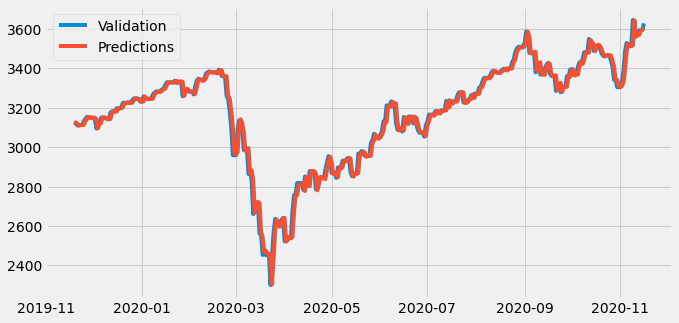

In [68]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.show()